In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import json
import itertools
from IPython.display import display
import re
# Use this to remove the color codes around the results in the ansi shell output
ansi_color_codes = re.compile(r'\x1B\[[0-?]*[ -/]*[@-~]')
# Allows us to see larger dataframes
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
path = 'nn_training_logs/'
experiments = ['false_false_binary', 'false_true_binary', 'true_true_binary', 'multi']
ncols = 6  # Number of output columns of callbacks during training.
epochs = 30
data = []
for experiment in experiments:
    # Each experiment was run across 4 GPUs, so the output results are
    # spread out across 4 files. We loop through those files.
    files = [z for z in os.listdir(path) if experiment in z]
    for file in files:
        with open(path + file, 'r') as rf:
            lines = rf.readlines()
            # Analyze experiment settings (same for all trials)
            deats = [l for l in lines if l.startswith('Running with settings: ')][0].split(
                'Running with settings: ')[1].replace("'", '"').replace(
                'False', 'false').replace('True', 'true')
            setting = json.loads(deats)
            # Split up data into each experiment run for 40 epochs.
            trials = ["{'include" + z for z in " ".join(lines).split("{'include")[1:]]
            for trial in trials:
                d = {}
                d.update(setting)
                # Add experiment settings
                job_settings = json.loads(trial.split("\n")[0].split(
                    '\n')[0].replace("'",'"').replace('True', 'true').replace(
                    'False', 'false').replace(' "eta_min": None,', ''))
                d.update(job_settings)
                r = trial.split(" -------  ------------  -----------  ------------  ----  ------")[1]
                top_epoch, _, val_acc, val_loss = [float(ansi_color_codes.sub('', y)) for y in 
                     [z for z in r.split("\n")[:epochs + 1]
                     if len(z.split()) == ncols][-1].split()[:4]]
                test_acc_top_val = float(
                    [z for z in r.split("\n") if '**' in z][0].split(': ')[-1])
                test_acc_last = float(
                    [z for z in r.split("\n") if ' * ' in z][0].split(': ')[-1])
                d['epoch_top_val'] = top_epoch
                d['test_acc_last'] = test_acc_last
                d['test_acc_top_val'] = test_acc_top_val
                d['top_val_acc'] = val_acc
                d['top_val_loss'] = val_loss
                d['task'] = experiment
                data.append(d)

In [3]:
uninteresting_cols = ['param_idx', 'num_param_blocks', 'use_crossval']
df = pd.DataFrame(data).drop(uninteresting_cols, axis=1)
len(df)

10752

In [105]:
# Store results
results = df.groupby(
        ['experiment_key', 'task', 'include_prior', 'history', 'future']
    )['test_acc_top_val'].max().reset_index()
tmap = ['false_false_binary', 'false_true_binary', 'true_true_binary', 'multi']
results['task_long_name'] = results['task']
results['task'] = [tmap.index(z) + 1 for z in results['task_long_name']]
results.to_csv('nn_training_logs/nn_all_task_scores.csv', index=False)

In [84]:
print('Number of unique minutes of converation:\n{:.2f} minutes'.format(
      pd.read_csv('/datasets/cgn/EGOCOM/video_info.csv').groupby(
          ['conversation_id'])['duration_seconds'].min().sum() / 3600))

Number of unique minutes of converation:
13.71 minutes


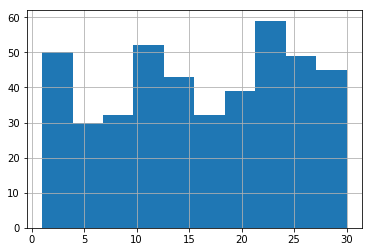

In [4]:
# Visualize choice of 40 epochs and see where does the max score occur.
lol = []
for i, sdf in df[(df['future'] > 1) & (df['include_prior'])].groupby(
            ['experiment_key', 'task', 'history', 'future']):
    lol.append(sdf[sdf['test_acc_top_val'] == sdf['test_acc_top_val'].max()])
pd.concat(lol)['epoch_top_val'].hist()

In [5]:
task_full_names = [
    "Binary Embodied Prediction: given any one person’s features, will that person be speaking in Y seconds",
    "Binary Host Prediction using Host-Features: given only the conversation host’s features, will the host be speaking in Y seconds",
    "Binary Host Prediction using Everyone’s-Features:given a concatenation of all participant’s features, will the host be speaking in Y seconds",
    "Multiclass Prediction: given all participant’s features, who will be speaking in Y seconds"
]

In [58]:
tex_start = '''
\\begin{tabular}{ll|cccc|cccc|cccc|cccc}
\\toprule
\\multicolumn{2}{l|}{(data used for training)  \\;\\, |\\;\\;\\;\\;\\;\\; Past (s)} & \\multicolumn{4}{c|}{4} & \\multicolumn{4}{c|}{5} & \\multicolumn{4}{c|}{10} & \\multicolumn{4}{c}{30} \\\\
 Include Prior & Modalities | \\; Future (s) &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 \\\\
\\midrule
'''

def make_table(df, include_prior, task, round_places=3):
    sdf = df[(df['include_prior'] == include_prior) & (df['task'] == task)]
    results = sdf.groupby(
        ['experiment_key', 'task', 'include_prior', 'history', 'future']
    )['test_acc_top_val'].max().reset_index().drop(
        ['include_prior', 'task'], axis = 1)
    table = results.groupby('experiment_key').apply(lambda x: x.set_index(['history', 'future']).drop('experiment_key', axis=1).T).round(round_places) * 100
    # Remove multi index that just says the same test-acc over and over
    table.index = [z.replace('vox', '').replace('_', '-') for z, _ in list(table.T.columns)]
    table = table.reindex(['text', 'video', 'audio', 'text-video', 'text-audio', 'video-audio',  'text-video-audio'])
    return table


def make_latex(table, str_info='', display_latex=True, round_places=3, multiclass=False):
    max_indicator = 10000
    texs = []
    for include_prior in [False, True]:
        table = make_table(df, include_prior, task)
        column_format="l|l|cccc|cccc|cccc|cccc"
        table = table.iloc[:, table.columns.get_level_values(1).isin([1,3,5,10])].round(round_places)
        # Add prior into index
        table.index = pd.MultiIndex.from_arrays(
            [[include_prior]*len(table),table.index],
            names=('Include Prior', 'Features'),
        )
        # Bold max values
        table_copy = pd.DataFrame(table, copy=True).round(round_places)
        # Add max_indicator to the max value in each column.
        for (h,f), v in table.idxmax(axis=0).iteritems():
            table_copy.loc[v, (h, f)] += max_indicator
        tex = table_copy.to_latex(column_format = column_format) #, bold_rows = True)
        for w in [w for w in tex.split() if w.startswith(str(max_indicator // 100))]:
            tex = tex.replace(w, "\\textbf{"+str(round(float(w) - max_indicator, round_places))+"}")
        tex = tex.replace("-", "+")
        texs.append(tex)
    # Combine the two tables
    tex = '\n'.join(texs[0].split('\n')[:-3] + texs[1].split('\n')[5:])
    # Fix header columns
    tex = tex_start + '\n'.join(tex.split('\n')[6:])
    return tex
    

In [59]:
for task in [z for z in experiments]:
    print(task)
    print()
    print(make_latex(table))
    print()

false_false_binary


\begin{tabular}{ll|cccc|cccc|cccc|cccc}
\toprule
\multicolumn{2}{l|}{(data used for training)  \;\, |\;\;\;\;\;\; Past (s)} & \multicolumn{4}{c|}{4} & \multicolumn{4}{c|}{5} & \multicolumn{4}{c|}{10} & \multicolumn{4}{c}{30} \\
 Include Prior & Modalities | \; Future (s) &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 &       1  &       3  &       5  &       10 \\
\midrule
False & text &     68.2 &     64.8 &     64.7 &     64.7 &     68.0 &     65.1 &     65.0 &     65.0 &     65.5 &     65.0 &     65.0 &     65.0 &     64.9 &     64.9 &     64.9 &  \textbf{64.9} \\
      & video &     67.2 &     64.8 &     64.7 &     64.7 &     65.0 &     65.0 &     65.0 &     65.0 &     65.2 &     65.0 &     65.0 &     65.0 &     64.9 &     64.9 &     64.9 &     64.9 \\
      & audio &     72.3 &  \textbf{69.3} &  \textbf{67.2} &     64.9 &     71.6 &     66.7 &     65.0 &     65.0 &  \textbf{69.

In [10]:
for task in [z for z in experiments]:
    for include_prior in [True, False]:
        print(task, " | include prior:", include_prior)
        sdf = df[(df['include_prior'] == include_prior) & (df['task'] == task)]
        results = sdf.groupby(
            ['experiment_key', 'task', 'include_prior', 'history', 'future']
        )['test_acc_top_val'].max().reset_index().drop(
            ['include_prior', 'task'], axis = 1)
        table = results[results.future.isin([1, 3, 5, 10])].groupby('experiment_key').apply(lambda x: x.set_index(['history', 'future']).drop('experiment_key', axis=1).T).round(3) * 100
        # Remove multi index that just says the same test-acc over and over
        table.index = [z.replace('vox', '').replace('_', '-') for z, _ in list(table.T.columns)]
        table = table.reindex(['text', 'video', 'audio', 'text-video', 'text-audio', 'video-audio',  'text-video-audio'])
        display(table)

false_false_binary  | include prior: True


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              74.9  65.2  64.7  64.7  75.5  66.7  65.0  65.0  74.8  65.5  65.0  65.0  75.0  65.5  64.9  64.9
video             73.7  65.1  64.7  64.7  73.0  65.6  65.1  65.0  73.4  65.7  65.0  65.0  74.4  68.2  66.1  65.2
audio             76.1  70.1  66.9  65.0  75.2  67.4  65.2  65.0  75.1  67.0  65.2  65.0  74.6  65.2  64.9  64.9
text-video        74.7  65.1  64.8  64.7  74.4  65.9  65.2  65.0  73.6  67.0  65.3  65.0  73.7  68.1  66.2  64.9
text-audio        76.2  69.2  67.3  65.2  75.7  68.5  65.4  65.0  75.2  68.2  65.5  65.0  75.0  65.6  65.0  64.9
video-audio       75.0  68.1  65.0  64.7  75.1  66.9  65.5  65.0  73.5  68.1  67.0  65.0  74.5  68.3  66.2  65.1
text-video-audio  75.4  67.7  65.2  65.4  75.5  66.2  66.6  65.2  73.9  67.4  66.0  65.0  74.3  69.0  66.5  65.0

false_false_binary  | include prior: False


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              68.2  64.8  64.7  64.7  68.0  65.1  65.0  65.0  65.5  65.0  65.0  65.0  64.9  64.9  64.9  64.9
video             67.2  64.8  64.7  64.7  65.0  65.0  65.0  65.0  65.2  65.0  65.0  65.0  64.9  64.9  64.9  64.9
audio             72.3  69.3  67.2  64.9  71.6  66.7  65.0  65.0  69.8  65.6  65.3  65.0  65.2  64.9  64.9  64.9
text-video        69.9  64.8  64.7  64.7  67.4  65.3  65.0  65.0  65.6  65.0  65.0  65.0  65.6  65.3  64.9  64.9
text-audio        73.4  68.3  66.7  65.0  72.1  67.1  65.1  65.1  69.6  66.5  65.4  65.0  65.8  64.9  64.9  64.9
video-audio       71.0  67.0  66.4  65.8  70.9  66.7  65.1  65.2  69.1  66.1  65.4  65.0  67.6  65.1  65.3  64.9
text-video-audio  72.4  67.6  65.2  64.8  72.1  66.0  65.4  65.9  69.5  65.4  65.6  65.2  66.7  66.2  65.0  64.9

false_true_binary  | include prior: True


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              71.6  62.2  58.7  57.9  72.3  62.3  58.2  57.9  71.2  61.5  58.7  55.4  72.2  61.8  56.8  51.9
video             67.5  56.8  53.2  57.3  72.2  58.5  58.0  57.1  69.7  60.9  55.3  55.8  71.3  62.6  60.2  56.7
audio             72.2  62.6  59.9  55.6  72.5  63.3  59.8  55.1  72.1  62.2  57.4  54.7  72.4  62.4  57.2  50.3
text-video        68.6  58.4  53.4  57.7  72.2  60.4  58.8  57.0  67.8  59.0  53.2  56.8  71.5  62.6  59.7  54.6
text-audio        71.7  62.7  58.9  56.5  72.1  63.2  59.4  56.9  70.6  62.8  58.4  55.4  71.8  59.8  57.4  50.3
video-audio       69.4  60.2  55.4  58.5  71.8  62.4  57.0  57.4  68.7  60.0  53.5  54.0  71.6  61.4  59.5  52.9
text-video-audio  71.1  60.8  56.8  57.8  71.7  62.4  55.8  56.9  70.0  59.8  53.5  53.8  71.2  62.5  59.2  51.4

false_true_binary  | include prior: False


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              65.6  60.5  56.0  57.3  64.7  59.9  56.2  57.7  58.9  55.7  54.1  52.6  51.6  51.0  50.2  51.2
video             59.2  53.6  52.5  56.0  59.8  52.8  56.9  56.6  58.4  57.5  50.6  50.8  56.8  56.3  55.3  53.8
audio             67.9  62.1  58.1  52.5  67.5  62.0  58.6  53.8  64.6  60.5  54.7  52.3  58.2  52.1  52.8  50.5
text-video        64.0  54.3  55.3  56.8  64.9  56.6  56.0  56.7  57.8  57.5  56.1  55.0  59.5  57.2  51.4  54.0
text-audio        68.3  62.1  58.1  54.8  67.6  61.8  58.3  52.9  64.6  60.9  55.4  53.0  55.6  50.3  51.0  50.2
video-audio       66.7  58.1  54.7  56.3  66.4  59.7  57.7  56.7  62.5  59.8  52.8  53.0  59.5  56.2  53.3  51.0
text-video-audio  67.4  61.3  53.6  56.8  67.4  60.5  53.7  57.1  63.8  59.0  52.2  53.1  58.5  55.9  53.3  50.3

true_true_binary  | include prior: True


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              68.1  59.7  57.8  55.2  68.5  60.5  56.3  56.2  66.6  59.4  57.4  55.4  67.8  58.4  56.1  55.3
video             63.1  57.6  54.7  54.3  65.2  58.9  55.6  55.3  62.8  57.1  57.0  55.4  63.6  57.0  55.9  55.7
audio             68.5  60.4  57.2  54.2  68.5  60.4  58.2  56.2  67.4  59.3  57.5  55.9  67.7  56.7  56.1  55.2
text-video        64.7  57.8  58.1  54.8  66.3  59.7  55.6  55.1  64.0  58.6  56.4  54.9  62.8  55.7  54.4  56.8
text-audio        68.0  60.7  57.3  54.3  68.6  60.5  57.3  56.1  67.1  58.2  57.1  56.5  67.0  57.0  56.0  55.1
video-audio       66.4  59.7  57.4  55.1  66.9  60.2  57.2  55.3  62.7  58.7  58.0  55.0  63.4  55.4  55.0  55.5
text-video-audio  67.1  60.3  57.3  54.6  67.1  60.3  56.9  55.4  64.1  58.1  57.2  55.0  63.4  55.4  54.1  55.7

true_true_binary  | include prior: False


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              64.0  58.9  56.6  54.5  63.0  58.7  56.4  56.0  60.5  57.2  56.9  55.3  56.2  55.2  55.3  55.3
video             58.8  57.2  57.0  54.6  59.6  57.3  56.7  55.4  59.8  57.3  56.6  54.8  55.2  55.5  55.0  55.2
audio             65.7  60.0  56.9  54.4  65.3  60.4  57.2  56.4  62.4  57.9  56.6  56.2  57.5  56.7  56.0  55.7
text-video        63.1  58.2  56.2  55.0  62.9  57.8  56.7  55.2  60.3  58.1  57.8  53.8  55.9  56.1  55.2  55.2
text-audio        66.1  60.3  56.6  54.2  66.3  60.5  56.9  55.8  62.6  58.1  56.8  56.0  57.1  56.3  57.1  55.3
video-audio       65.1  59.3  57.0  54.3  64.4  60.6  56.6  55.7  62.7  58.9  56.5  53.3  56.3  56.4  55.0  55.7
text-video-audio  66.1  59.8  57.8  54.9  64.8  60.1  56.9  55.3  61.8  57.8  55.8  55.1  55.9  55.9  55.0  56.2

multi  | include prior: True


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              56.8  48.8  47.5  45.8  56.4  47.9  45.3  44.6  53.5  46.8  45.2  45.0  55.2  46.6  44.8  44.7
video             48.2  45.3  42.7  44.3  51.8  45.6  45.8  45.8  45.8  45.7  44.7  44.8  50.7  45.7  44.7  44.7
audio             56.5  49.0  47.7  46.2  57.2  48.4  46.4  44.9  54.2  47.0  46.3  45.1  55.1  45.7  45.0  44.5
text-video        52.1  46.8  44.4  44.4  53.2  46.1  45.8  44.8  47.9  45.6  44.6  44.9  49.8  46.2  43.1  44.7
text-audio        56.9  49.0  47.8  46.1  56.9  48.5  46.3  44.8  54.3  47.0  46.0  44.7  54.4  45.9  45.0  44.9
video-audio       53.5  47.4  46.8  45.8  54.3  47.7  46.8  45.1  49.4  46.7  44.6  44.6  50.7  44.6  44.1  44.7
text-video-audio  55.4  47.0  46.7  43.9  55.1  47.3  46.3  44.8  48.7  45.9  45.3  44.2  50.7  44.8  43.2  42.6

multi  | include prior: False


history             4                       5                       10                      30                  
future              1     3     5     10    1     3     5     10    1     3     5     10    1     3     5     10
text              53.5  47.8  47.3  45.9  51.6  47.5  45.6  44.9  48.6  45.1  44.8  45.1  44.8  44.0  44.8  44.7
video             44.6  45.3  43.9  42.2  45.4  45.0  44.9  44.9  44.4  45.8  45.1  44.4  43.2  44.8  44.8  44.6
audio             53.7  48.6  47.8  46.3  52.6  48.0  46.3  45.5  49.9  46.4  46.3  45.2  45.6  43.4  44.8  43.6
text-video        48.3  44.9  43.7  44.5  48.5  45.3  45.4  44.5  45.1  44.2  45.1  44.5  40.1  44.5  44.7  44.5
text-audio        54.5  48.3  47.7  46.0  53.5  48.2  46.2  45.3  49.9  47.1  45.7  44.7  44.0  44.4  44.9  44.7
video-audio       51.6  47.2  46.9  42.1  52.2  46.9  45.5  44.9  46.9  45.0  45.2  44.9  44.0  44.3  44.9  44.8
text-video-audio  53.0  47.0  46.8  44.0  53.1  46.6  45.6  44.9  47.4  45.7  45.7  44.9  42.7  43.3  43.6  44.4

In [73]:
gb_cols

['conversation_id',
 'clip_id',
 'multiclass_speaker_label',
 'test',
 'train',
 'val']

In [9]:
df_copy[]

Index(['video_id', 'clip_id', 'video_speaker_id', 'is_speaking', 'multiclass_speaker_label', 'videofeat_0', 'videofeat_1', 'videofeat_2', 'videofeat_3', 'videofeat_4',
       ...
       'native_speaker', 'video_name', 'background_fan', 'background_music', 'cid', 'train', 'val', 'test', 'prior_is_speaking', 'prior_multiclass_speaker_label'], dtype='object', length=2883)

In [12]:
tmp = df_copy[df_copy['video_speaker_id'] == 1]
sum(tmp['is_speaking'] == tmp['prior_is_speaking']) / len(tmp)

0.7558731885849943

In [20]:
data.columns

Index(['video_id', 'clip_id', 'video_speaker_id', 'is_speaking', 'multiclass_speaker_label', 'videofeat_0', 'videofeat_1', 'videofeat_2', 'videofeat_3', 'videofeat_4',
       ...
       'native_speaker', 'video_name', 'background_fan', 'background_music', 'cid', 'train', 'val', 'test', 'prior_is_speaking', 'prior_multiclass_speaker_label'], dtype='object', length=2883)

In [23]:
for dataset in ['test', 'train']:
    print(dataset)
    data = new_data[new_data[dataset]]
    print(sum(data['is_speaking'] == data['prior_is_speaking']) / len(data))
    tmp = data[data['video_speaker_id'] == 1]
    print(sum(tmp['is_speaking'] == tmp['prior_is_speaking']) / len(tmp))
    print(sum(data['multiclass_speaker_label'] == data['prior_multiclass_speaker_label']) / len(data))


test
0.7558731885849943
0.7263074064242102
0.6231762203867649
train
0.7729024111710474
0.7448055822157661
0.648370115219995


In [29]:
# Compute priors for train and test set
for history in [4]:  # [4, 5, 10, 30]:
    for future in [1, 5, 10]:  # [1, 5, 10]:
        print('history:', history, 'future:', future)
        hdf5_fn = 'egocom_feature_data_normalized_history_{}_future_{}_binary' \
                  '.hdf5'.format(history, future)
        new_data = pd.read_hdf(egocom_loc + hdf5_fn, key=hdf5_fn)
        for dataset in ['test', 'train']:
            print(dataset)
            data = new_data[new_data[dataset]]
            print(round(sum(data['is_speaking'] == data['prior_is_speaking']) / len(data), 3))
            tmp = data[data['video_speaker_id'] == 1]
            print(round(sum(tmp['is_speaking'] == tmp['prior_is_speaking']) / len(tmp), 3))
            print(round(sum(data['multiclass_speaker_label'] == data['prior_multiclass_speaker_label']) / len(data), 3))

history: 4 future: 1
test
0.756
0.726
0.623
train
0.773
0.745
0.648
history: 4 future: 5
test
0.655
0.613
0.477
train
0.673
0.621
0.501
history: 4 future: 10
test
0.632
0.585
0.445
train
0.643
0.587
0.458


In [4]:
# Find the accuracy we can get by just predicting f(x) = 1 (simplest model)
# for the multi-class prediction task.
egocom_loc = "/datasets/cgn/EGOCOM/egocom_features/no_audio/"
for history in [4]:  # [4, 5, 10, 30]:
    for future in [1]:  # [1, 5, 10]:
        print('history:', history, 'future:', future)
        hdf5_fn = 'egocom_feature_data_normalized_history_{}_future_{}_binary' \
                  '.hdf5'.format(history, future)
        new_data = pd.read_hdf(egocom_loc + hdf5_fn, key=hdf5_fn)
        # Task 1 Binary any baseline
        df_copy = new_data.copy()
        b = df_copy['is_speaking'].value_counts() / len(df_copy)
        print(b)
        print('Task 1 f(x) = 1 model accuracy is:', b[0])
        # Task 2 Binary host baseline
        df_copy = new_data.copy()
        tmp = df_copy[df_copy['speaker_is_host']]
        b = tmp['is_speaking'].value_counts() / len(tmp)
        print(b)
        print('Task 2 f(x) = 1 model accuracy is:', b[0])
        # Task 3 Binary host (concat perspectives) baseline
        df_copy = new_data.copy()# Only use 3 speaker conversations
        tmp = df_copy[df_copy['num_speakers'] == 3]
        # Combine all three speakers to single input for each conversation
        y = tmp.groupby(["conversation_id", "clip_id", "test", "train", "val"])[
            'multiclass_speaker_label'].apply(
            lambda x: x.iloc[0] == 1)
        b = y.value_counts() / len(y)
        print(b)
        print('Task 3 f(x) = 1 model accuracy is:', b[0])
        # Multiclass baseline
        gb_cols = ['conversation_id', 'clip_id', 'multiclass_speaker_label', 'test', 'train', 'val']
        df_copy = new_data.copy()
        tmp = df_copy[df_copy['num_speakers'] == 3]
        b = tmp[gb_cols].drop_duplicates()['multiclass_speaker_label'].value_counts() / len(tmp[gb_cols].drop_duplicates())
        print(b)
        print('task 4 f(x) = 1 model accuracy is:', b[1])

history: 4 future: 1
0    0.654655
1    0.345345
Name: is_speaking, dtype: float64
Task 1 f(x) = 1 model accuracy is: 0.6546551395147441
0    0.507094
1    0.492906
Name: is_speaking, dtype: float64
Task 2 f(x) = 1 model accuracy is: 0.5070937934418186
False    0.536216
True     0.463784
Name: multiclass_speaker_label, dtype: float64
Task 3 f(x) = 1 model accuracy is: 0.5362162433490614
1    0.463784
3    0.292566
2    0.212052
0    0.031598
Name: multiclass_speaker_label, dtype: float64
task 4 f(x) = 1 model accuracy is: 0.4637837566509387


In [ ]:

if use_all_perspectives:
    # Only use 3 speaker conversations
    new_data = new_data[new_data['num_speakers'] == 3]
elif predict_only_host:
    # Only use host data and none of the other perspectives.
    new_data = new_data[new_data['speaker_is_host']]

if use_all_perspectives:
    # Combine all three speakers to single input for each conversation
    X = new_data.groupby(
        ["conversation_id", "clip_id", "multiclass_speaker_label",
         "test", "train", "val"]).apply(
        lambda x: x[experiment].values.flatten()).reset_index()
    if predict_only_host:
        # Only use hosts labels.
        y = new_data.groupby(["conversation_id", "clip_id",
                              "test", "train", "val"])[
            'multiclass_speaker_label'].apply(
            lambda x: x.iloc[0] == 1)